<a href="https://colab.research.google.com/github/Victor-Manach/numerai/blob/main/numerai_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q numerapi

In [ ]:
!pip install -q --no-deps numerai-tools

In [ ]:
from typing import List, Dict, Any, Literal, Optional, Tuple, Callable
from pathlib import Path
import pandas as pd
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from dataclasses import dataclass
import math
from torch.utils.data import TensorDataset, DataLoader, Dataset
import time
import matplotlib.pyplot as plt
import seaborn as sns

from numerai_tools.scoring import numerai_corr, correlation_contribution
from tqdm.notebook import tqdm

import h5py

plt.rcParams["figure.figsize"] = (10, 5)

In [ ]:
path_to_drive = Path('/content/drive/My Drive')

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device=}")

device='cuda'


In [ ]:
DATA_VERSION = "v5.0"
MODEL_NAME = "MLP_WITH_INFERENCE_ADAPTER"
PATH_TO_DATA = path_to_drive / f"numerai/data/{DATA_VERSION}"
SKIP_TRAINING = False

In [ ]:
features_path = PATH_TO_DATA / "features.json"
TRAIN_PATH = PATH_TO_DATA / "train/train_v2.h5"
VALID_PATH = PATH_TO_DATA / "valid/valid_v2.h5"

MODEL_PATH = path_to_drive / f"numerai/models"

In [ ]:
feature_metadata = json.load(open(features_path))
all_target_cols = feature_metadata["targets"]
feature_sets = feature_metadata["feature_sets"]

sm_feature_set = feature_sets["small"]
med_feature_set = feature_sets["medium"]
all_feature_set = feature_sets["all"]

ERA_COL = "era"
MAIN_TARGET = "target"
AUXILIARY_TARGETS = [
  "target_victor_20",
  "target_xerxes_20",
  "target_teager2b_20",
  "target_caroline_20",
  "target_sam_20",
  "target_echo_20",
  "target_alpha_20",
  "target_jeremy_20"
]

feature_set = med_feature_set

In [ ]:
class InfiniteDataIterator:
    def __init__(self, dataloader, split):
        self.dataloader = dataloader
        self._iterator = iter(dataloader)
        self.split = split

    def __iter__(self):
        return self

    def __next__(self):
        try:
            return next(self._iterator)
        except StopIteration:
            print(f"Restarting data loader ({self.split} split)...")
            self._iterator = iter(self.dataloader)
            return next(self._iterator)

    def reset(self):
        print(f"Resetting data loader ({self.split} split)...")
        self._iterator = iter(self.dataloader)

In [ ]:
def load_features_id(features_to_use, h5_file):
    feature_to_id_file = h5_file.parent / "feature_to_id.json"
    with open(feature_to_id_file, 'r') as f:
        feature_to_id = json.load(f)
    features_id = [feature_to_id[f] for f in features_to_use]

    return features_id

def load_targets_id(targets_to_use, h5_file):
    target_to_id_file = h5_file.parent / "target_to_id.json"
    with open(target_to_id_file, 'r') as f:
        target_to_id = json.load(f)
    targets_id = [target_to_id[t] for t in targets_to_use]

    return targets_id

def load_target_id(target_to_use, h5_file):
    target_to_id_file = h5_file.parent / "target_to_id.json"
    with open(target_to_id_file, 'r') as f:
        target_to_id = json.load(f)
    target_id = target_to_id[target_to_use]

    return target_id

def load_eras_data(keep_eras, h5_file, target_to_use=None):
    if target_to_use is not None:
        target_id = load_target_id(target_to_use, h5_file)
    else:
        target_id = None
    era_vector = []
    with h5py.File(h5_file, 'r') as f:
        era_ix = f['era_index']
        idx_list = []
        if keep_eras is not None:
            for era in keep_eras:
                era_key = str(era).zfill(4)
                if era_key in era_ix:
                    idx_list.append(era_ix[era_key][:])
                    era_vector.append([era]*len(era_ix[era_key]))
            if idx_list:
                indices = np.concatenate(idx_list)
            else:
                indices = np.array([], dtype=np.int64)
            features = f['features'][indices, :]
        else:
            features = f['features'][:]

        if target_id is not None:
            if keep_eras is not None:
                targets = f['targets'][indices, target_id]
            else:
                targets = f['targets'][:, target_id]
        else:
            if keep_eras is not None:
                targets = f['targets'][indices, :]
            else:
                targets = f['targets'][:]

    era_vector = np.concatenate(era_vector)
    return features, targets, era_vector

def load_first_n_eras_data(n, h5_file, target_to_use=None):
    if target_to_use is not None:
        target_id = load_target_id(target_to_use, h5_file)
    else:
        target_id = None

    era_vector = []
    with h5py.File(h5_file, 'r') as f:
        era_ix = f['era_index']
        era_keys = sorted(list(era_ix.keys()))
        first_n_keys = era_keys[:n]
        idx_list = []
        for era_key in first_n_keys:
            idx_list.append(era_ix[era_key][:])
            era_vector.append([int(era_key)]*len(era_ix[era_key]))
        if idx_list:
            indices = np.concatenate(idx_list)
        else:
            indices = np.array([], dtype=np.int64)
        features = f['features'][indices, :]
        if target_id is not None:
            targets = f['targets'][indices, target_id]
        else:
            targets = f['targets'][indices, :]

    era_vector = np.concatenate(era_vector)
    return features, targets, era_vector, [int(e) for e in first_n_keys]


def load_eras_data_and_filter_columns(keep_eras, h5_file, features_to_use, target_to_use=None):
    features, targets, era_vector = load_eras_data(keep_eras, h5_file, target_to_use)
    features_id = load_features_id(features_to_use, h5_file)

    return features[:, features_id], targets, era_vector

def load_first_n_eras_data_and_filter_columns(n, h5_file, features_to_use, target_to_use=None):
    features, targets, era_vector, first_n_eras = load_first_n_eras_data(n, h5_file, target_to_use)
    features_id = load_features_id(features_to_use, h5_file)

    return features[:, features_id], targets, era_vector, first_n_eras

In [ ]:
train_eras = [i for i in range(500, 600)]
# train_eras = [i for i in range(500, 950)]
x_train_np, y_train_np, train_era_vector_np = load_eras_data_and_filter_columns(train_eras, TRAIN_PATH, feature_set, None)

In [ ]:
main_target_id = load_target_id(MAIN_TARGET, TRAIN_PATH)
aux_target_ids = load_targets_id(AUXILIARY_TARGETS, TRAIN_PATH)

y_train_main_np = y_train_np[:, main_target_id]
y_train_aux_np = y_train_np[:, aux_target_ids]

In [ ]:
x_train = torch.tensor(x_train_np, dtype=torch.float32)
y_train_main = torch.tensor(y_train_main_np, dtype=torch.float32)
y_train_aux = torch.tensor(y_train_aux_np, dtype=torch.float32)
train_era_vector_pt = torch.tensor(train_era_vector_np, dtype=torch.int32)

x_train.shape, y_train_main.shape, y_train_aux.shape, train_era_vector_pt.shape

(torch.Size([536631, 705]),
 torch.Size([536631]),
 torch.Size([536631, 8]),
 torch.Size([536631]))

In [ ]:
train_era_vector_pt.min(), train_era_vector_pt.max()

(tensor(500, dtype=torch.int32), tensor(599, dtype=torch.int32))

In [ ]:
x_train = (x_train - 2.0) / 2.0

In [ ]:
y_train_main.unique(), y_train_aux.unique()

(tensor([0.0000, 0.2500, 0.5000, 0.7500, 1.0000]),
 tensor([0.0000, 0.2500, 0.5000,  ...,    nan,    nan,    nan]))

In [ ]:
x_train = x_train.float()
y_train_main = y_train_main.float()
y_train_aux = y_train_aux.float()

In [ ]:
# n = 150
n = 50
x_valid_np, y_valid_np, valid_era_vector_np, valid_eras = load_first_n_eras_data_and_filter_columns(n, VALID_PATH, feature_set, None)

In [ ]:
main_target_id = load_target_id(MAIN_TARGET, VALID_PATH)
aux_target_ids = load_targets_id(AUXILIARY_TARGETS, VALID_PATH)

y_valid_main_np = y_valid_np[:, main_target_id]
y_valid_aux_np = y_valid_np[:, aux_target_ids]

In [ ]:
x_valid = torch.tensor(x_valid_np, dtype=torch.float32)
y_valid_main = torch.tensor(y_valid_main_np, dtype=torch.float32)
y_valid_aux = torch.tensor(y_valid_aux_np, dtype=torch.float32)
valid_era_vector_pt = torch.tensor(valid_era_vector_np, dtype=torch.int32)

x_valid.shape, y_valid_main.shape, y_valid_aux.shape, valid_era_vector_pt.shape

(torch.Size([340746, 705]),
 torch.Size([340746]),
 torch.Size([340746, 8]),
 torch.Size([340746]))

In [ ]:
valid_era_vector_pt.min(), valid_era_vector_pt.max()

(tensor(975, dtype=torch.int32), tensor(1024, dtype=torch.int32))

In [ ]:
x_valid = (x_valid - 2.0) / 2.0

In [ ]:
y_valid_main.unique(), y_valid_aux.unique()

(tensor([0.0000, 0.2500, 0.5000, 0.7500, 1.0000]),
 tensor([0.0000, 0.2500, 0.5000,  ...,    nan,    nan,    nan]))

In [ ]:
x_valid = x_valid.float()
y_valid_main = y_valid_main.float()
y_valid_aux = y_valid_aux.float()

----

In [ ]:
class AdapterBlock(nn.Module):
    def __init__(self, config, device=None, dtype=None):
        super().__init__()

        factory_kwargs = {'device': device, 'dtype': dtype}
        self.ln = nn.LayerNorm(config.n_embd, **factory_kwargs)
        self.down_proj = nn.Linear(config.n_embd, config.adapter_dim, bias=config.bias, **factory_kwargs)
        self.up_proj = nn.Linear(config.adapter_dim, config.n_embd, bias=config.bias, **factory_kwargs)
        self.gelu = nn.GELU()

    def forward(self, x):
        # x = self.ln(x)
        x = self.down_proj(x)
        x = self.gelu(x)
        x = self.up_proj(x)
        return x


class MlpBlock(nn.Module):
    def __init__(self, config, device=None, dtype=None):
        super().__init__()

        factory_kwargs = {'device': device, 'dtype': dtype}
        self.ln = nn.LayerNorm(config.n_embd, **factory_kwargs)
        self.c_fc = nn.Linear(config.n_embd, config.n_embd, bias=config.bias, **factory_kwargs)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias, **factory_kwargs)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.ln(x)
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x


class MlpBackbone(nn.Module):
    def __init__(self, config, device=None, dtype=None):
        super().__init__()

        factory_kwargs = {'device': device, 'dtype': dtype}
        self.embedding = nn.Linear(config.input_dim, config.n_embd, bias=True, **factory_kwargs)
        self.layers = nn.ModuleList([MlpBlock(config, **factory_kwargs) for _ in range(config.n_layers)])

    def forward(self, x):
        x = self.embedding(x)
        for layer in self.layers:
            x_ffn = layer(x)
            x = x + x_ffn

        return x


class MlpBlockWithAdapter(nn.Module):
    def __init__(self, mlp_block:MlpBlock, config, device=None, dtype=None):
        super().__init__()

        factory_kwargs = {'device': device, 'dtype': dtype}
        self.base_block = mlp_block
        self.adapter_block = AdapterBlock(config, **factory_kwargs)

    def forward(self, x):
        x = x + self.base_block(x)
        x = x + self.adapter_block(x)

        return x


class MlpBackboneWithAdapter(nn.Module):
    def __init__(self, mlp_backbone:MlpBackbone, config, device=None, dtype=None):
        super().__init__()

        factory_kwargs = {'device': device, 'dtype': dtype}
        for block in mlp_backbone.layers:
            for name, param in block.named_parameters():
                if "ln" not in name:
                    param.requires_grad = False

        self.embedding = mlp_backbone.embedding
        # for param in self.embedding.parameters():
        #     param.requires_grad = False

        self.mlp_blocks_with_adapter = nn.ModuleList(
            [MlpBlockWithAdapter(mlp_block, config, **factory_kwargs) for mlp_block in mlp_backbone.layers])

    def forward(self, x):
        x = self.embedding(x)
        for layer in self.mlp_blocks_with_adapter:
            x = layer(x)

        return x

class ReconstructionHead(nn.Module):
    def __init__(self, config, device=None, dtype=None):
        super().__init__()

        factory_kwargs = {'device': device, 'dtype': dtype}
        self.proj = nn.Linear(config.n_embd, config.input_dim, bias=True, **factory_kwargs)

    def forward(self, x):
        return self.proj(x)

class RegressionHead(nn.Module):
    def __init__(self, config, device=None, dtype=None):
        super().__init__()

        factory_kwargs = {'device': device, 'dtype': dtype}
        self.main_proj = nn.Linear(config.n_embd, config.main_output_dim, bias=True, **factory_kwargs)
        self.aux_proj = nn.Linear(config.n_embd, config.aux_output_dim, bias=True, **factory_kwargs)

    def forward(self, x):
        return self.main_proj(x), self.aux_proj(x)

In [ ]:
class MlpReconstructModel(nn.Module):
    def __init__(self, config, device=None, dtype=None):
        super().__init__()

        factory_kwargs = {'device': device, 'dtype': dtype}
        self.backbone = MlpBackbone(config, **factory_kwargs)
        self.head = ReconstructionHead(config, **factory_kwargs)

        self.config = config

    def forward(self, x):
        x, mask = self.apply_mask(x)
        x = self.backbone(x)

        return self.head(x), mask

    def apply_mask(self, x):
        mask = torch.rand_like(x) < self.config.mask_ratio
        noise = torch.randn_like(x) * self.config.noise_std
        x_masked = x.clone()
        x_masked[mask] = noise[mask]
        return x_masked, mask

In [ ]:
class MlpRegressionModel(nn.Module):
    def __init__(self, config, device=None, dtype=None):
        super().__init__()

        factory_kwargs = {'device': device, 'dtype': dtype}
        self.backbone = MlpBackbone(config, **factory_kwargs)
        self.head = RegressionHead(config, **factory_kwargs)

        self.config = config

    def forward(self, x):
        x = self.backbone(x)

        return self.head(x)

In [ ]:
class MlpReconstructWithAdapterModel(nn.Module):
    def __init__(self, mlp_backbone:MlpBackbone, config, device=None, dtype=None):
        super().__init__()

        factory_kwargs = {'device': device, 'dtype': dtype}
        self.backbone_with_adapter = MlpBackboneWithAdapter(mlp_backbone, config, **factory_kwargs)
        self.head = ReconstructionHead(config, **factory_kwargs)

        self.config = config

    def forward(self, x):
        x, mask = self.apply_mask(x)
        x = self.backbone_with_adapter(x)

        return self.head(x), mask

    def apply_mask(self, x):
        mask = torch.rand_like(x) < self.config.mask_ratio
        noise = torch.randn_like(x) * self.config.noise_std
        x_masked = x.clone()
        x_masked[mask] = noise[mask]
        return x_masked, mask

In [ ]:
class MlpRegressionWithAdapterModel(nn.Module):
    def __init__(self, mlp_backbone:MlpBackboneWithAdapter, head, device=None, dtype=None):
        super().__init__()

        factory_kwargs = {'device': device, 'dtype': dtype}
        self.backbone_with_adapter = mlp_backbone
        self.head = head

        self.config = config

    def forward(self, x):
        x = self.backbone_with_adapter(x)

        return self.head(x)

In [ ]:
class MlpReconstructWithAdapterAndConsistency(nn.Module):
    def __init__(self,
                 frozen_backbone: MlpBackbone,
                 backbone_with_adapter: MlpBackboneWithAdapter,
                 config,
                 device=None,
                 dtype=None):
        super().__init__()

        factory_kwargs = {'device': device, 'dtype': dtype}
        self.config = config

        self.frozen_backbone = frozen_backbone
        for param in self.frozen_backbone.parameters():
            param.requires_grad = False

        self.backbone_with_adapter = backbone_with_adapter
        self.head = ReconstructionHead(config, **factory_kwargs)

    def apply_mask(self, x):
        mask = torch.rand_like(x) < self.config.mask_ratio
        noise = torch.randn_like(x) * self.config.noise_std
        x_masked = x.clone()
        x_masked[mask] = noise[mask]
        return x_masked, mask

    def forward(self, x):
        x_masked, mask = self.apply_mask(x)
        h_orig = self.frozen_backbone(x_masked)
        h_adapt = self.backbone_with_adapter(x_masked)
        recon = self.head(h_adapt)

        return recon, mask, h_orig, h_adapt

In [ ]:
@dataclass
class Config:
    input_dim: int
    main_output_dim: int
    aux_output_dim: int
    n_layers: int
    n_embd: int
    adapter_dim: int
    dropout: float
    bias: bool
    mask_ratio: float
    noise_std: float

@dataclass
class MlpReconstructConfig:
    input_dim: int
    main_output_dim: int
    aux_output_dim: int
    n_layers: int
    n_embd: int
    dropout: float
    bias: bool
    mask_ratio: float
    noise_std: float

In [ ]:
checkpoint = torch.load(MODEL_PATH/f"MLP_RECONSTRUCT.pt", map_location=device, weights_only=False)

In [ ]:
config = Config(
    input_dim=len(feature_set),
    main_output_dim=1,
    aux_output_dim=len(AUXILIARY_TARGETS),
    n_layers=4,
    n_embd=256,
    adapter_dim=32,
    dropout=0.0,
    bias=True,
    mask_ratio=0.4,
    noise_std=0.1
)

----

In [ ]:
def configure_optimizer(model, weight_decay, learning_rate, betas, device_type, print_):
    param_dict = {pn: p for pn, p in model.named_parameters() if p.requires_grad}
    decay_params = [p for n, p in param_dict.items() if p.dim() >= 2] # all weight tensors in matmuls + embeddings decay
    nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2] # all biases and layernorms

    optim_groups = [
        {'params': decay_params, 'weight_decay': weight_decay},
        {'params': nodecay_params, 'weight_decay': 0.0}
    ]
    num_decay_params = sum(p.numel() for p in decay_params)
    num_nodecay_params = sum(p.numel() for p in nodecay_params)
    if print_:
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")

    use_fused = (device_type == 'cuda')
    extra_args = dict(fused=True) if use_fused else dict()

    optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, **extra_args)
    if print_:
        print(f"using fused AdamW: {use_fused}")

    return optimizer

In [ ]:
batch_size = 512
total_batch_size = 721920
assert total_batch_size % (batch_size*config.input_dim) == 0
grad_accum_steps = total_batch_size // (batch_size*config.input_dim)
print(f"Total desired batch size: {total_batch_size}")
print(f"=> calculated gradient accumulation steps: {grad_accum_steps}")

Total desired batch size: 721920
=> calculated gradient accumulation steps: 2


In [ ]:
backbone_ckpt = {k:v for (k,v) in checkpoint["model"].items() if "main_proj" not in k}
backbone_for_reg_model_ckpt = {f"backbone.{k}":v for (k,v) in backbone_ckpt.items()}

reconstruct_head_ckpt = {k:v for (k,v) in checkpoint["model"].items() if "main_proj" in k}
reconstruct_head_ckpt = {"head."+k.replace("main_proj", "proj"): v for (k,v) in reconstruct_head_ckpt.items()}

In [ ]:
mlp_backbone = MlpBackbone(config).to(device)
missing_keys, unexpected_keys = mlp_backbone.load_state_dict(backbone_ckpt, strict=False)

print("Missing keys:", missing_keys)
print("Unexpected keys:", unexpected_keys)

Missing keys: []
Unexpected keys: []


In [ ]:
reg_model = MlpRegressionModel(config).to(device)
missing_keys, unexpected_keys = reg_model.load_state_dict(backbone_for_reg_model_ckpt, strict=False)

print("Missing keys:", missing_keys)
print("Unexpected keys:", unexpected_keys)

Missing keys: ['head.main_proj.weight', 'head.main_proj.bias', 'head.aux_proj.weight', 'head.aux_proj.bias']
Unexpected keys: []


In [ ]:
def print_trainable_parameters(model):
    n_params = sum(p.numel() for p in model.parameters())
    n_params_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"[{model.__class__.__name__}] Number of trainable parameters: {n_params_trainable:,} out of {n_params:,} total parameters.")

In [ ]:
print_trainable_parameters(reg_model)

[MlpRegressionModel] Number of trainable parameters: 711,433 out of 711,433 total parameters.


In [ ]:
def display_pt_model_params(module: nn.Module):
    print("\nModel Parameters:\n")
    print(f"{'Layer':<100} {'# Parameters':>15} {'Shape':>20}")
    print("-" * 150)
    total_params = 0

    for name, param in module.named_parameters():
        if param.requires_grad:
            num_params = param.numel()
            total_params += num_params
            print(f"{name:<100} {num_params:>15,} {str(tuple(param.shape)):>20}")

    print("-" * 150)
    print(f"{'Total':<100} {total_params:>15,} params\n")

In [ ]:
display_pt_model_params(reg_model)


Model Parameters:

Layer                                                                                                   # Parameters                Shape
------------------------------------------------------------------------------------------------------------------------------------------------------
backbone.embedding.weight                                                                                    180,480           (256, 705)
backbone.embedding.bias                                                                                          256               (256,)
backbone.layers.0.ln.weight                                                                                      256               (256,)
backbone.layers.0.ln.bias                                                                                        256               (256,)
backbone.layers.0.c_fc.weight                                                                                 65,536           (256, 256)
b

In [ ]:
train_dataset = TensorDataset(x_train, y_train_main, y_train_aux, train_era_vector_pt)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)

In [ ]:
valid_dataset = TensorDataset(x_valid, y_valid_main, y_valid_aux, valid_era_vector_pt)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

In [ ]:
len(train_loader), len(valid_loader)

(1049, 666)

In [ ]:
max_steps = 4000 # 9200
val_loss_n_steps = 200
learning_rate = 6e-4
decay_lr = True
warmup_iters = 400 # 400
lr_decay_iters = max_steps # should be ~= max_iters
min_lr = 6e-5 # should be ~= learning_rate/10
weight_decay = 1e-1
betas = (0.9, 0.999)
epsilon = 1e-8
gamma = 3.0
n_steps_for_adapter = 600

dtype = torch.bfloat16 if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else torch.float16
torch.set_float32_matmul_precision("high")

torch.manual_seed(1337)
torch.cuda.manual_seed_all(1337)

In [ ]:
reg_optimizer = configure_optimizer(reg_model, weight_decay, learning_rate, betas, device, print_=True)

num decayed parameter tensors: 11, with 707,072 parameters
num non-decayed parameter tensors: 19, with 4,361 parameters
using fused AdamW: True


In [ ]:
def get_lr(it, warmup_iters, learning_rate, lr_decay_iters, min_lr):
    # 1) linear warmup for warmup_iters steps
    if it < warmup_iters:
        return learning_rate * (it + 1) / (warmup_iters + 1)
    # 2) if it > lr_decay_iters, return min learning rate
    if it > lr_decay_iters:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
    return min_lr + coeff * (learning_rate - min_lr)

get_lr_with_default_values = lambda it: get_lr(it, warmup_iters, learning_rate, lr_decay_iters, min_lr)

In [ ]:
def weighted_mse_loss(main_pred, aux_pred, y_main_true, y_aux_true):
    main_pred = main_pred.view(-1)
    y_main_true = y_main_true.view(-1)

    w_main = 1.0 + gamma * torch.abs(y_main_true - 0.5) / 0.5
    loss = w_main * (main_pred - y_main_true) ** 2

    mask_aux = ~torch.isnan(y_aux_true)
    y_aux_true = torch.where(mask_aux, y_aux_true, torch.tensor(0.0, dtype=y_aux_true.dtype, device=y_aux_true.device))
    aux_loss = (((aux_pred - y_aux_true) ** 2) * mask_aux.float()).sum() / (mask_aux.float().sum() + epsilon)

    return torch.mean(loss) + 0.5 * aux_loss

In [ ]:
def masked_mse_loss(pred, target, mask):
    return ((pred - target)**2 * mask.float()).sum() / mask.float().sum().clamp_min(epsilon)

def masked_mse_loss_with_consistency(pred, target, mask, h_orig, h_adapt, lambda_):
    consistency_loss = F.mse_loss(h_adapt, h_orig)
    return masked_mse_loss(pred, target, mask) + lambda_ * consistency_loss

In [ ]:
@torch.no_grad()
def run_regression_eval_loop(model, valid_loader_iter, n_valid_steps, loss_fn):
    model.eval()
    valid_loader_iter.reset()
    val_loss_accum = 0.0
    for _ in range(n_valid_steps):
        xb, yb_main, yb_aux, _ = next(valid_loader_iter)
        xb, yb_main, yb_aux = xb.to(device), yb_main.to(device), yb_aux.to(device)
        with torch.autocast(device_type=device, dtype=dtype):
            main_logits, aux_logits = model(xb)
            loss = loss_fn(main_logits, aux_logits, yb_main, yb_aux)
        loss = loss / n_valid_steps
        val_loss_accum += loss.detach()

    return val_loss_accum

In [ ]:
def train_adapter_on_dataset(mlp_backbone, config, loader_iter, n_steps, grad_accum_steps, loss_fn):
    backbone = MlpBackbone(config).to(device)
    backbone.load_state_dict(mlp_backbone.state_dict())

    backbone_with_adapter = MlpBackboneWithAdapter(backbone, config)
    model = MlpReconstructWithAdapterAndConsistency(backbone, backbone_with_adapter, config).to(device)

    # display_pt_model_params(model)

    optimizer = configure_optimizer(model, weight_decay, learning_rate, betas, device, print_=False)

    model.train(True)
    loader_iter.reset()

    for step in range(n_steps):
        last_step = (step == n_steps - 1)
        t0 = time.time()
        optimizer.zero_grad()
        loss_accum = 0.0
        for micro_step in range(grad_accum_steps):
            xb, _, _, _ = next(loader_iter)
            xb = xb.to(device)

            with torch.autocast(device_type=device, dtype=dtype):
                xb_hat, mask, h_orig, h_adapt = model(xb)
                loss = loss_fn(xb_hat, xb, mask, h_orig, h_adapt, lambda_=0.4)

            loss = loss / grad_accum_steps
            loss_accum += loss.detach()
            loss.backward()
        norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        t1 = time.time()
        dt = t1 - t0
        if step % 10 == 0 or last_step:
            print(f"[{model.__class__.__name__}] step {step+1:3d}/{n_steps:3d} | loss={loss_accum.item():.6f} | lr={learning_rate:.6e} | norm={norm:.4f} | dt={dt*1000:.2f}ms")

    return model

In [ ]:
def run_eval_loop_with_adapter(model, valid_loader_iter, config, n_steps, n_valid_steps):
    adapter_model = train_adapter_on_dataset(model.backbone, config, valid_loader_iter, n_steps, 1, masked_mse_loss_with_consistency)
    reg_model_with_adapter = MlpRegressionWithAdapterModel(adapter_model.backbone_with_adapter, model.head).to(device)
    val_loss = run_regression_eval_loop(reg_model_with_adapter, valid_loader_iter, n_valid_steps, weighted_mse_loss)
    return reg_model_with_adapter, val_loss

In [ ]:
def run_train_step(model, optimizer, train_loader_iter, step, loss_fn):
    model.train(True)
    lr = get_lr_with_default_values(step) if decay_lr else learning_rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    optimizer.zero_grad()
    loss_accum = 0.0
    for micro_step in range(grad_accum_steps):
        xb, yb_main, yb_aux, _ = next(train_loader_iter)
        xb, yb_main, yb_aux = xb.to(device), yb_main.to(device), yb_aux.to(device)

        with torch.autocast(device_type=device, dtype=dtype):
            main_logits, aux_logits = model(xb)
            loss = loss_fn(main_logits, aux_logits, yb_main, yb_aux)

        loss = loss / grad_accum_steps
        loss_accum += loss.detach()
        loss.backward()
    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()

    return loss_accum, norm, lr

In [ ]:
train_losses, valid_losses, valid_losses_with_adapter = [], [], []

train_loader_iter = InfiniteDataIterator(train_loader, "train")
valid_loader_iter = InfiniteDataIterator(valid_loader, "valid")
n_valid_steps = len(valid_loader)
for step in range(max_steps):
    t0 = time.time()
    last_step = (step == max_steps - 1)

    if step % val_loss_n_steps == 0 or last_step:
        val_loss = run_regression_eval_loop(reg_model, valid_loader_iter, n_valid_steps, weighted_mse_loss)
        print(f"[{reg_model.__class__.__name__}] step {step+1:3d}/{max_steps:3d} | val_loss={val_loss.item():.4f}")
        valid_losses.append(val_loss.item())

        reg_model_with_adapter, val_loss_with_adapter = run_eval_loop_with_adapter(reg_model, valid_loader_iter, config, n_steps_for_adapter, n_valid_steps)
        print(f"[{reg_model_with_adapter.__class__.__name__}] step {step+1:3d}/{max_steps:3d} | val_loss={val_loss_with_adapter.item():.4f}")
        valid_losses_with_adapter.append(val_loss_with_adapter.item())

    loss_accum, norm, lr = run_train_step(reg_model, reg_optimizer, train_loader_iter, step, weighted_mse_loss)

    if torch.cuda.is_available():
        torch.cuda.synchronize()
    t1 = time.time()
    dt = t1 - t0
    if step % 50 == 0 or last_step:
        print(f"[{reg_model.__class__.__name__}] step {step+1:3d}/{max_steps:3d} | loss={loss_accum.item():.6f} | lr={lr:.6e} | norm={norm:.4f} | dt={dt*1000:.2f}ms")

    train_losses.append(loss_accum.item())

Resetting data loader (valid split)...
[MlpRegressionModel] step   1/4000 | val_loss=1.1463
Resetting data loader (valid split)...
[MlpReconstructWithAdapterAndConsistency] step   1/600 | loss=0.637228 | lr=6.000000e-04 | norm=0.1308 | dt=482.41ms
[MlpReconstructWithAdapterAndConsistency] step  11/600 | loss=0.512301 | lr=6.000000e-04 | norm=0.0632 | dt=11.80ms
[MlpReconstructWithAdapterAndConsistency] step  21/600 | loss=0.437016 | lr=6.000000e-04 | norm=0.0520 | dt=9.14ms
[MlpReconstructWithAdapterAndConsistency] step  31/600 | loss=0.389662 | lr=6.000000e-04 | norm=0.0431 | dt=8.92ms
[MlpReconstructWithAdapterAndConsistency] step  41/600 | loss=0.356932 | lr=6.000000e-04 | norm=0.0376 | dt=7.53ms
[MlpReconstructWithAdapterAndConsistency] step  51/600 | loss=0.328232 | lr=6.000000e-04 | norm=0.0340 | dt=10.76ms
[MlpReconstructWithAdapterAndConsistency] step  61/600 | loss=0.313615 | lr=6.000000e-04 | norm=0.0324 | dt=9.40ms
[MlpReconstructWithAdapterAndConsistency] step  71/600 | los

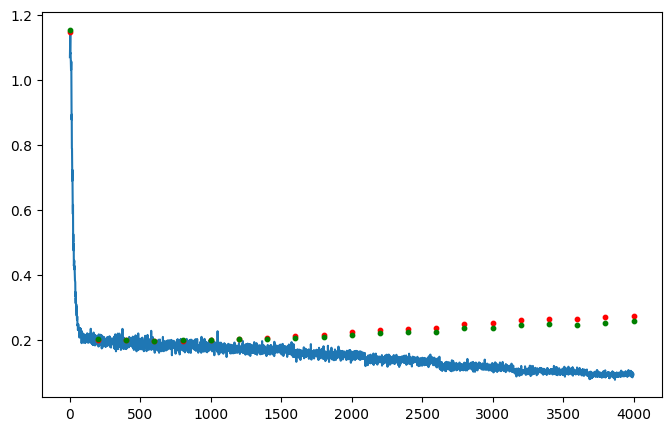

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(np.arange(len(train_losses)), train_losses)
plt.scatter(np.arange(len(valid_losses))*val_loss_n_steps, valid_losses, color='red', zorder=3, s=10)
plt.scatter(np.arange(len(valid_losses_with_adapter))*val_loss_n_steps, valid_losses_with_adapter, color='green', zorder=3, s=10)
plt.show()

# Save the model

In [ ]:
checkpoint = {
    'model': reg_model.state_dict()
}
torch.save(checkpoint, MODEL_PATH/"MLP_SMALL_V2.pt")

In [ ]:
assert False, "stop here"

AssertionError: stop here

----
# Validation

In [ ]:
reg_model.eval()

In [ ]:
inference_train_loader = train_loader

In [ ]:
train_predictions = []
train_targets = []
used_train_eras = []

with torch.no_grad():
    for batch in tqdm(inference_train_loader):
        features, targets, _, eras = batch
        features = features.to(device)

        with torch.autocast(device_type=device, dtype=dtype):
            t_predictions, _ = reg_model(features)

        predictions = t_predictions.squeeze(-1).float().cpu().numpy()
        targets = targets.numpy()

        train_predictions.append(predictions)
        train_targets.append(targets)
        used_train_eras.append(eras)

train_predictions = np.concatenate(train_predictions, axis=0)
train_targets = np.concatenate(train_targets, axis=0)
used_train_eras = np.concatenate(used_train_eras, axis=0)

In [ ]:
df_train_preds = pd.DataFrame(
    data = {
        'era': [str(era).zfill(4) for era in used_train_eras],
        'target': train_targets,
        MODEL_NAME: train_predictions
    }
)

In [ ]:
df_train_preds[MODEL_NAME].describe()

In [ ]:
sns.set(style="darkgrid", context="talk", palette="rainbow", font_scale=.7)
sns.histplot(data=df_train_preds, x=MODEL_NAME, bins=200)

# Customize the plot to match your original settings
plt.title("Train predictions")
plt.xlabel('Observation')   # Remove x-axis label
plt.ylabel('')  # Optional: Set y-axis label
plt.legend([], [], frameon=False)  # Remove legend
plt.tight_layout()
plt.show()

In [ ]:
per_era_corr = df_train_preds.groupby("era").apply(
    lambda x: numerai_corr(x[[MODEL_NAME]].dropna(), x['target'].dropna()),
    include_groups=False
)

sns.set(style="darkgrid", context="talk", palette="rainbow", font_scale=.7)
sns.barplot(data=per_era_corr, x='era', y=MODEL_NAME)

# Customize the plot to match your original settings
plt.title("Train CORR")
plt.xticks([])  # Remove x-tick labels
plt.xlabel('era')   # Remove x-axis label
plt.ylabel('')  # Optional: Set y-axis label
plt.legend([], [], frameon=False)  # Remove legend
plt.tight_layout()
plt.show()

In [ ]:
sns.set(style="darkgrid", context="talk", palette="rainbow", font_scale=.7)
sns.lineplot(data=per_era_corr.cumsum(), x='era', y=MODEL_NAME)

# Customize the plot to match your original settings
plt.title("Cumulative Train CORR")
plt.xticks([])  # Remove x-tick labels
plt.xlabel('era')   # Remove x-axis label
plt.ylabel('')  # Optional: Set y-axis label
plt.legend([], [], frameon=False)  # Remove legend
plt.tight_layout()
plt.show()

----

In [ ]:
inference_valid_loader = valid_loader

In [ ]:
valid_predictions = []
valid_targets = []
used_valid_eras = []

with torch.no_grad():
    for batch in tqdm(inference_valid_loader):
        features, targets, _, eras = batch
        features = features.to(device)

        with torch.autocast(device_type=device, dtype=dtype):
            t_predictions, _ = reg_model(features)

        predictions = t_predictions.squeeze(-1).float().cpu().numpy()
        targets = targets.numpy()

        valid_predictions.append(predictions)
        valid_targets.append(targets)
        used_valid_eras.append(eras)

valid_predictions = np.concatenate(valid_predictions, axis=0)
valid_targets = np.concatenate(valid_targets, axis=0)
used_valid_eras = np.concatenate(used_valid_eras, axis=0)

In [ ]:
df_validation_preds = pd.DataFrame(
    data = {
        'era': [str(era).zfill(4) for era in used_valid_eras],
        'target': valid_targets,
        MODEL_NAME: valid_predictions
    }
).dropna()

In [ ]:
df_validation_preds[MODEL_NAME].describe()

In [ ]:
# Compute the per-era corr between our predictions and the target values
per_era_corr = df_validation_preds.groupby("era").apply(
    lambda x: numerai_corr(x[[MODEL_NAME]].dropna(), x['target'].dropna()),
    include_groups=False
)

sns.set(style="darkgrid", context="talk", palette="rainbow", font_scale=.7)
sns.barplot(data=per_era_corr, x='era', y=MODEL_NAME)

# Customize the plot to match your original settings
plt.title("Validation CORR")
plt.xticks([])  # Remove x-tick labels
plt.xlabel('era')   # Remove x-axis label
plt.ylabel('')  # Optional: Set y-axis label
plt.legend([], [], frameon=False)  # Remove legend
plt.tight_layout()
plt.show()

In [ ]:
sns.set(style="darkgrid", context="talk", palette="rainbow", font_scale=.7)
sns.lineplot(data=per_era_corr.cumsum(), x='era', y=MODEL_NAME)

# Customize the plot to match your original settings
plt.title("Cumulative Validation CORR")
plt.xticks([])  # Remove x-tick labels
plt.xlabel('era')   # Remove x-axis label
plt.ylabel('')  # Optional: Set y-axis label
plt.legend([], [], frameon=False)  # Remove legend
plt.tight_layout()
plt.show()

In [ ]:
# Compute performance metrics
corr_mean = per_era_corr.mean()
corr_std = per_era_corr.std(ddof=0)
corr_sharpe = corr_mean / corr_std
corr_max_drawdown = (per_era_corr.cumsum().expanding(min_periods=1).max() - per_era_corr.cumsum()).max()

pd.DataFrame({
    "mean": [corr_mean.values[0]],
    "std": [corr_std.values[0]],
    "sharpe": [corr_sharpe.values[0]],
    "max_drawdown": [corr_max_drawdown.values[0]]
}, index=["CORR"]).T